Load the required libraries and data. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime
#now = datetime.datetime.now()



In [14]:
train = pd.read_csv('../data/train.zip')
test = pd.read_csv('../data/test.zip')
macro = pd.read_csv('../data/macro.csv')
id_test = test.id
train.sample(3)
# Any results you write to the current directory are saved as output.

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
25644,25647,2014-12-02,39,22.0,2.0,12.0,5.0,1974.0,2.0,6.0,...,24,4,0,5,19,1,4,49,5,7200000
18934,18937,2014-05-27,41,27.0,4.0,5.0,2.0,1966.0,2.0,5.0,...,3,3,0,7,16,0,9,49,10,6500000
28683,28686,2015-03-28,38,NaN,5.0,17.0,1.0,NaN,1.0,0.0,...,1,1,0,2,12,0,0,9,0,5437752


In [15]:
#It seems that this doen't improve anything. 

#train["timestamp"] = pd.to_datetime(train["timestamp"])
#train["year"], train["month"], train["day"] = train["timestamp"].dt.year,train["timestamp"].dt.month,train["timestamp"].dt.day

#test["timestamp"] = pd.to_datetime(test["timestamp"])
#test["year"], test["month"], test["day"] = test["timestamp"].dt.year,test["timestamp"].dt.month,test["timestamp"].dt.day

In [16]:

y_train = train["price_doc"]
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

#can't merge train with test because the kernel run for very long time

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)        

In [17]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse'
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

[18:52:54] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:52:54] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:52:54] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:8205920.00000	test-rmse:8210065.00000
[50]	train-rmse:2537120.08333	test-rmse:2904030.16667
[100]	train-rmse:2195528.83333	test-rmse:2717538.50000
[150]	train-rmse:2073892.41667	test-rmse:2679376.00000
[200]	train-rmse:1982897.70833	test-rmse:2657502.41667
[250]	train-rmse:1911955.33333	test-rmse:2647057.16667
[300]	train-rmse:1853126.25000	test-rmse:2640952.16667
[350]	train-rmse:1796067.41667	test-rmse:2636093.33333
[400]	train-rmse:1747625.50000	test-rmse:2632504.50000
[450]	train-rmse:1700335.00000	test-rmse:26

<AxesSubplot:>

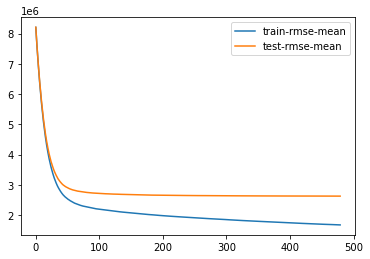

In [18]:
cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

In [19]:
num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)

[18:54:42] WARNING: c:\ci\xgboost-split_1638290375667\work\src\objective\regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:42] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

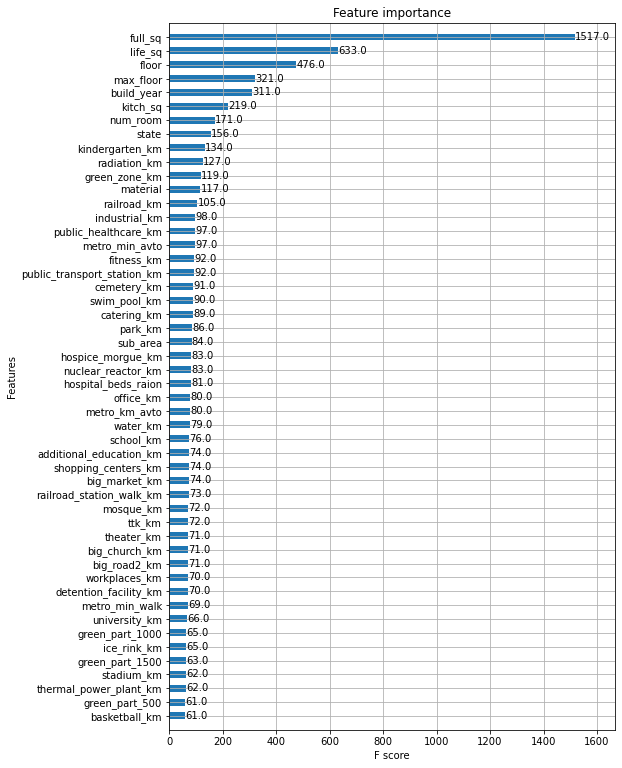

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [21]:
y_predict = model.predict(dtest)
output = pd.DataFrame({'id': id_test, 'price_doc': y_predict})
output.head()

,id,price_doc
0,30474,5688934.0
1,30475,8313294.0
2,30476,5617120.5
3,30477,5942706.5
4,30478,5281467.0


In [22]:
output.to_csv('./output_models/xgbSub.csv', index=False)